Buy at 7926.7 on 2016-01-01 09:34:00
Sell at 7922.9 on 2016-01-01 09:45:00 - Return: -0.05%
Buy at 7924.35 on 2016-01-01 09:47:00
Sell at 7929.65 on 2016-01-01 10:10:00 - Return: 0.07%
Buy at 7939.55 on 2016-01-01 10:17:00
Sell at 7934.4 on 2016-01-01 10:32:00 - Return: -0.06%
Buy at 7937.4 on 2016-01-01 10:44:00
Sell at 7944.0 on 2016-01-01 11:20:00 - Return: 0.08%
Buy at 7944.25 on 2016-01-01 11:35:00
Sell at 7941.65 on 2016-01-01 11:39:00 - Return: -0.03%
Buy at 7943.3 on 2016-01-01 11:52:00
Sell at 7942.4 on 2016-01-01 12:14:00 - Return: -0.01%
Buy at 7939.65 on 2016-01-01 12:36:00
Sell at 7933.3 on 2016-01-01 12:43:00 - Return: -0.08%
Buy at 7936.5 on 2016-01-01 12:56:00
Sell at 7935.15 on 2016-01-01 13:06:00 - Return: -0.02%
Buy at 7932.15 on 2016-01-01 13:31:00
Sell at 7963.3 on 2016-01-01 14:38:00 - Return: 0.39%
Buy at 7965.85 on 2016-01-01 15:03:00
Sell at 7964.65 on 2016-01-01 15:12:00 - Return: -0.02%
Buy at 7963.05 on 2016-01-01 15:18:00
Sell at 7963.05 on 2016-01-01 15:19

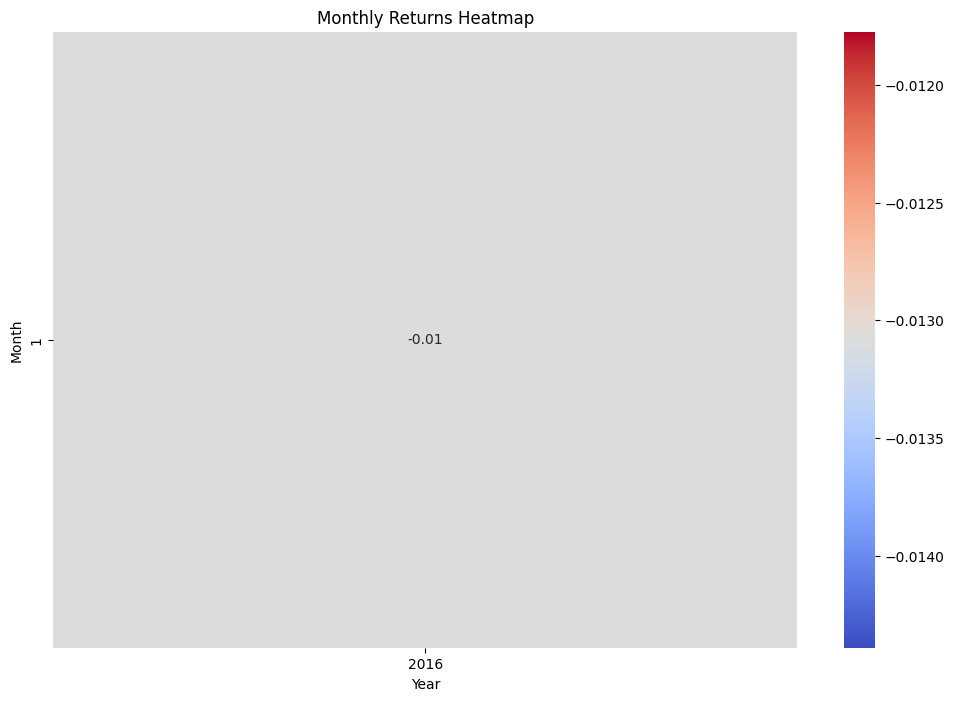

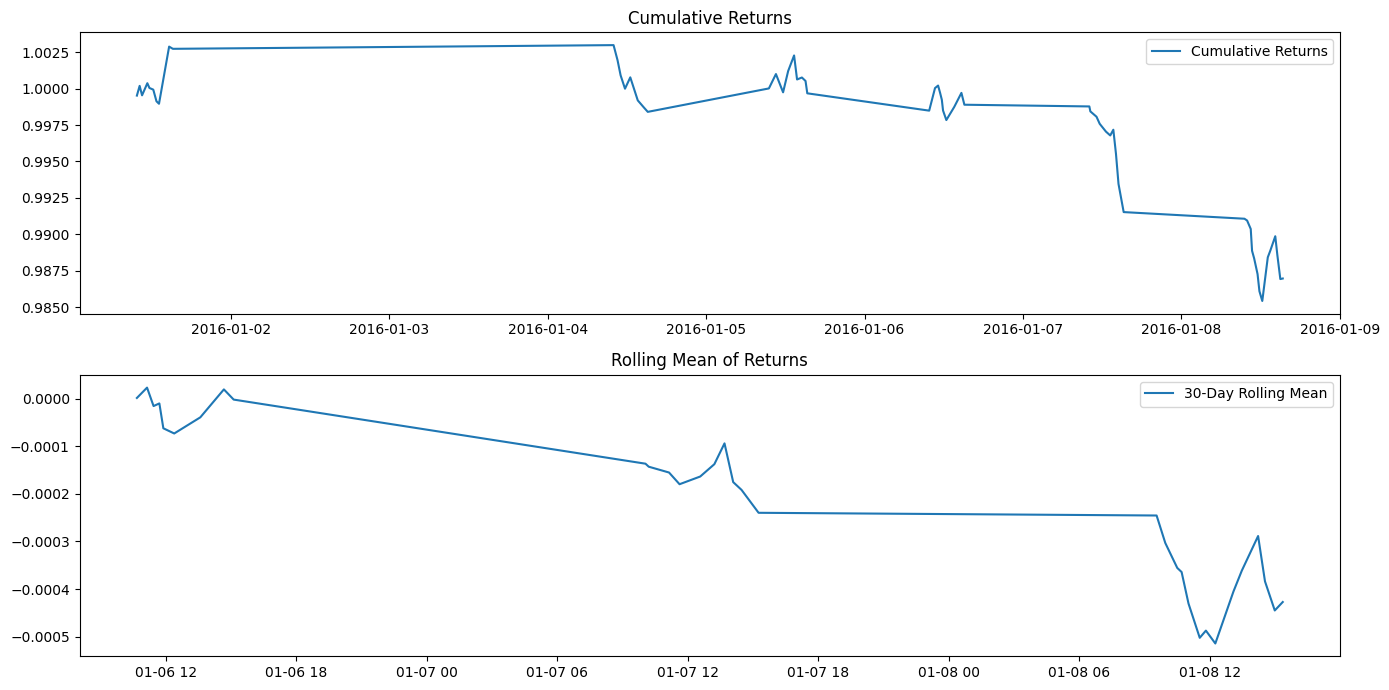

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load and preprocess the data
file_path = '/content/NIFTY 50 - Minute data.csv'  # Adjust this path if necessary
data = pd.read_csv(file_path)

# Rename columns for consistency
data.rename(columns={
    'date': 'Date',
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close'
}, inplace=True)

# Keep relevant columns
columns_to_keep = ['Date', 'Close']
data = data[columns_to_keep]

# Convert 'Date' to datetime with error handling
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
data.set_index('Date', inplace=True)

# Define and apply the strategy
def strategy_build(df):
    df['SMA_9'] = df['Close'].rolling(window=9, min_periods=1).mean()
    df['SMA_20'] = df['Close'].rolling(window=20, min_periods=1).mean()
    df['Signal'] = 0
    df.loc[df['SMA_9'] > df['SMA_20'], 'Signal'] = 1
    df.loc[df['SMA_9'] < df['SMA_20'], 'Signal'] = -1
    return df

class TradingExecution:
    def __init__(self):
        self.position = 0
        self.entry_price = 0.0
        self.stop_loss_level = 0.05
        self.returns = []

    def run(self, df, ticker, start_date, end_date):
        # Ensure the DataFrame is sorted by date
        df = df.sort_index()

        # Check if provided dates are within the data range
        if not (start_date in df.index and end_date in df.index):
            raise ValueError("The specified date range is not within the data index.")

        df = df.loc[start_date:end_date]

        for i in range(len(df)):
            current_date = df.index[i]
            signal = df['Signal'].iloc[i]
            close_price = df['Close'].iloc[i]

            if signal == 1 and self.position == 0:
                self.position = 1
                self.entry_price = close_price
                self.trade_open = current_date
                print(f"Buy at {close_price} on {current_date}")

            elif signal == -1 and self.position == 1:
                self.position = 0
                trade_return = (close_price - self.entry_price) / self.entry_price
                self.returns.append((current_date, trade_return))
                print(f"Sell at {close_price} on {current_date} - Return: {trade_return:.2%}")

            elif self.position == 1:
                if (close_price - self.entry_price) / self.entry_price <= -self.stop_loss_level:
                    self.position = 0
                    trade_return = (close_price - self.entry_price) / self.entry_price
                    self.returns.append((current_date, trade_return))
                    print(f"Sell at {close_price} on {current_date} - Stop Loss Hit: {trade_return:.2%}")

        returns_df = pd.DataFrame(self.returns, columns=['Date', 'Return'])
        returns_df.set_index('Date', inplace=True)
        return returns_df['Return']

# Post-Trade Analysis Class
class PostTradeAnalysis:
    def __init__(self, returns_series):
        """
        Initialize with a returns series or DataFrame containing return data.

        Parameters:
        returns_series (pd.Series or pd.DataFrame): Series or DataFrame of returns.
        """
        if isinstance(returns_series, pd.DataFrame):
            returns_series = returns_series['Return']

        if returns_series.empty:
            raise ValueError("Returns series is empty. Ensure that the trading strategy is working correctly.")

        self.returns = returns_series
        self.cumulative_returns = (self.returns + 1).cumprod()

    def get_cumulative_returns(self):
        """
        Calculate cumulative returns.

        Returns:
        pd.Series: Cumulative returns of the trading strategy.
        """
        return self.cumulative_returns

    def maximum_drawdown(self):
        """
        Calculate the maximum drawdown.

        Returns:
        float: Maximum drawdown experienced by the strategy.
        """
        roll_max = self.cumulative_returns.cummax()
        drawdown = (self.cumulative_returns - roll_max) / roll_max
        return drawdown.min()

    def sharpe_ratio(self, risk_free_rate=0.0):
        """
        Calculate the Sharpe ratio.

        Parameters:
        risk_free_rate (float): Risk-free rate to be subtracted from returns.

        Returns:
        float: Sharpe ratio of the strategy.
        """
        excess_returns = self.returns - risk_free_rate
        return (excess_returns.mean() / excess_returns.std()) * np.sqrt(252)

    def sortino_ratio(self, risk_free_rate=0.0):
        """
        Calculate the Sortino ratio.

        Parameters:
        risk_free_rate (float): Risk-free rate to be subtracted from returns.

        Returns:
        float: Sortino ratio of the strategy.
        """
        excess_returns = self.returns - risk_free_rate
        downside_returns = excess_returns[excess_returns < 0]
        return (excess_returns.mean() / downside_returns.std()) * np.sqrt(252)

    def hit_ratio(self):
        """
        Calculate the percentage of profitable trades.

        Returns:
        float: Percentage of profitable trades.
        """
        return (self.returns > 0).mean() * 100

    def monthly_returns_heatmap(self):
        """
        Generate a heatmap of monthly returns for each year.

        Returns:
        None: Displays a heatmap plot.
        """
        self.returns.index = pd.to_datetime(self.returns.index)  # Ensure index is DatetimeIndex
        monthly_returns = self.returns.resample('M').sum()
        monthly_returns = monthly_returns.to_frame(name='Monthly Return')
        monthly_returns['Year'] = monthly_returns.index.year
        monthly_returns['Month'] = monthly_returns.index.month
        heatmap_data = monthly_returns.pivot(index='Month', columns='Year', values='Monthly Return')

        plt.figure(figsize=(12, 8))
        sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt='.2f')
        plt.title('Monthly Returns Heatmap')
        plt.show()

    def plots(self):
        """
        Generate plots for cumulative returns and other relevant metrics.

        Returns:
        None: Displays plots.
        """
        plt.figure(figsize=(14, 7))
        plt.subplot(2, 1, 1)
        plt.plot(self.cumulative_returns, label='Cumulative Returns')
        plt.title('Cumulative Returns')
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(self.returns.rolling(window=30).mean(), label='30-Day Rolling Mean')
        plt.title('Rolling Mean of Returns')
        plt.legend()

        plt.tight_layout()
        plt.show()

# Example usage
if __name__ == "__main__":
    # Load example data
    data = pd.read_csv('/content/NIFTY 50 - Minute data.csv')
    data.rename(columns={
        'date': 'Date',
        'close': 'Close'
    }, inplace=True)
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data.set_index('Date', inplace=True)

    # Apply trading strategy
    data = strategy_build(data)

    # Execute trading strategy
    trader = TradingExecution()
    returns = trader.run(data, 'NIFTY', '2016-01-01', '2016-01-10')

    # Post-trade analysis
    analysis = PostTradeAnalysis(returns)

    print(f"Cumulative Returns:\n{analysis.get_cumulative_returns().tail()}")
    print(f"Maximum Drawdown: {analysis.maximum_drawdown():.2%}")
    print(f"Sharpe Ratio: {analysis.sharpe_ratio():.2f}")
    print(f"Sortino Ratio: {analysis.sortino_ratio():.2f}")
    print(f"Hit Ratio: {analysis.hit_ratio():.2f}%")

    analysis.monthly_returns_heatmap()
    analysis.plots()
